The notes here are derived from *Solving differential equations with Deep Learning: a beginner's guide* by Navarro, Moreno, Rodrigo (2023) as well as the tensorflow code.

# Physics-Informed Neural Networks (PINNs) for Ordinary Differential Equations

## 1. Mathematical Formulation of PINN for ODE

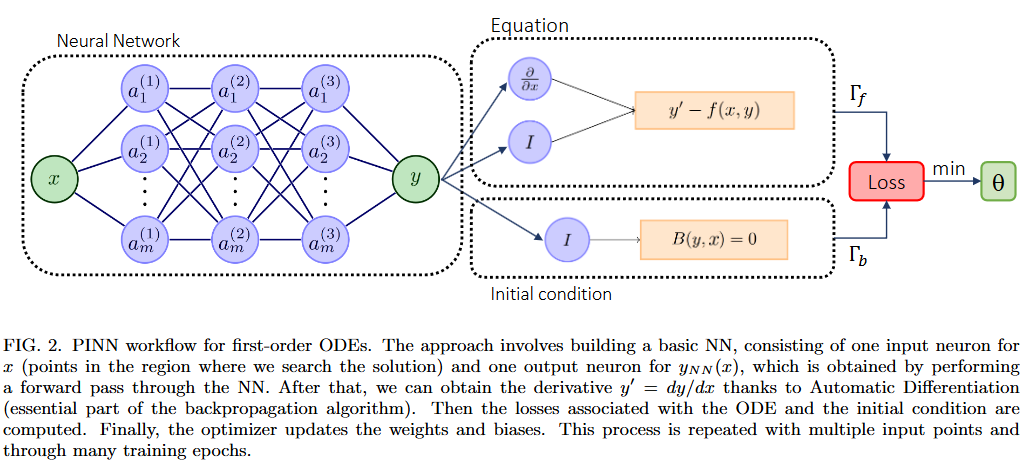

(Image from *Solving differential equations with Deep Learning: a beginner's guide* by Navarro, Moreno, Rodrigo (2023))

Consider a general PDE that has the form $$\begin{cases}\mathcal{D}(\mathbf{x}, u(\mathbf{x})) := \mathcal{D}(\mathbf{x}, u(\mathbf{x}), \nabla u, \Delta u, \dots,) = 0, & x \in \Omega \subset \mathbb{R}^d \\ \mathcal{B}(\mathbf{x}, u(\mathbf{x})) = 0, & \mathbf{x} \in \partial \Omega.\end{cases} \tag{$\star$}$$

*Solution using PINN*:
1. Choose a set of $N_\mathcal{B}$ points $\Gamma_{\mathcal{B}} \subset \partial \Omega$ and a set of $N_{\mathcal{D}}$ points $\Gamma_{\mathcal{D}} \subset \Omega$ so that $$\Gamma = \Gamma_{\mathcal{B}} \cup \Gamma_{\mathcal{D}} = \{\mathbf{x}_0, \dots, \mathbf{x}_M\}, \qquad M = N_\mathcal{B} + N_{\mathcal{D}}.$$
2. For training the PINN, define a **loss function** as a weighted sum $$L(\boldsymbol\theta, \Gamma) = \omega_{\mathcal{D}} L_{\mathcal{D}}(\mathbf{\boldsymbol\theta}, \Gamma_{\mathcal{D}}) + \omega_\mathcal{B} L_\mathcal{B}(\boldsymbol \theta, \Gamma_\mathcal{B}),$$ where $\omega_\mathcal{D}$ and $\omega_\mathcal{B}$ are hyperparameters that must be tuned (usually set to 1). A common practice is to choose the loss functions $$\begin{align*}
L_\mathcal{D}(\boldsymbol{\theta}, \Gamma_\mathcal{D}) &= \frac{1}{N_\mathcal{D}} \sum_{\mathbf{x} \in \Gamma_\mathcal{D}} \left|\mathcal{D}(\mathbf{x}, u(\mathbf{x}))\right|^2 \\ L_\mathcal{B}(\boldsymbol \theta, \Gamma_\mathcal{B}) &= \frac{1}{N_\mathcal{B}} \left|\mathcal{B}(\mathbf{x}, u(\mathbf{x}))\right|^2
\end{align*}$$

*Using PINN for first-order ODE*: 

Consider a 1st-order ODE of the following form $$y'(x) = f(x, y), \qquad y_{x_0} = y_0.$$ We define $\mathcal{D}$, $\mathcal{B}$ as $$\begin{align*} \mathcal{D}(x, y, y') &= 0 && \to &&y'(x) - f(x, y) = 0, \\ \mathcal{B}(y_0, x_0) &= 0 &&\to &&y(x_0) - y_0 = 0.\end{align*}$$

> The ODE and initial condition loss functions are $$\begin{align*}
L_\mathcal{D}(\boldsymbol{\theta}, \Gamma_\mathcal{D}) &= \frac{1}{N_\mathcal{D}} \sum_{i=1}^{N_\mathcal{D}} \left[y_{NN}'(x_i, \boldsymbol{\theta}) - f(x_i, y_{NN}(x_i, \boldsymbol{\theta}))\right]^2 \\
L_\mathcal{B}(\boldsymbol{\theta}, \Gamma_\mathcal{B}) &= \left|y_{NN}(x_0, \boldsymbol{\theta}) - y_0\right|^2
\end{align*}$$

To train successfully, we find a set of optimum weights and biases values $\boldsymbol \theta_{opt}$ so that $L_{\mathcal{D}}(\boldsymbol \theta_{opt}, \Gamma_{\mathcal{D}}, L_{\mathcal{B}}(\boldsymbol \theta_{opt}, \Gamma_\mathcal{B}) \approx 0$.

## 2. Examples

### 2.1 Example \#1

Let's approximate a solution to the ODE $$y'(x) + y(x) = 0, \qquad x \in (0, 4), \qquad y(0) = 1, \tag{1}$$ which has the exact solution $y(x) = e^{-x}$. 

**Import the required packages.**

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

**Definition of the PINN**

In [ ]:
class ODE_1st(tf.keras.Model):
    def train_step(self, data):
        # Training points and the analytical (exact) solution at this points
        x, y_exact = data
        # Initial conditions for the PINN
        x0=tf.constant([0.0], dtype=tf.float32)
        y0_exact=tf.constant([1.0], dtype=tf.float32)
        # Calculate the gradients and update weights and bias
        with tf.GradientTape() as tape:
            # Calculate the gradients dy/dx
            with tf.GradientTape() as tape2:
              tape2.watch(x0)
              tape2.watch(x)
              y0_NN = self(x0, training=True)
              y_NN  = self(x, training=True)
            dy_dx_NN= tape2.gradient(y_NN,x)
            #Loss= ODE+ boundary/initial conditions
            loss=self.compiled_loss(dy_dx_NN, -y_NN)\
                +self.compiled_loss(y0_NN,y0_exact)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(y_exact, y_NN)
        return {m.name: m.result() for m in self.metrics}

**Running the PINN**

In [ ]:
n_train = 20
xmin = 0
xmax = 4

# Definition of the function domain
x_train=np.linspace(xmin,xmax,n_train)

# The real solution y(x) for training evaluation
y_train=tf.exp(-x_train)

# Input and output neurons (from the data)
input_neurons  = 1
output_neurons = 1

# Hiperparameters
epochs = 40

# Definition of the the model
activation='elu'
input=Input(shape=(input_neurons,))
x=Dense(50, activation=activation)(input)
x=Dense(50, activation=activation)(x)
x=Dense(50, activation=activation)(x)
output = Dense(output_neurons,activation=None)(x)
model=ODE_1st(input,output)

# Definition of the metrics, optimizer and loss
loss= tf.keras.losses.MeanSquaredError()
metrics=tf.keras.metrics.MeanSquaredError()
optimizer= Adam(learning_rate=0.001)

model.compile(loss=loss,
          optimizer=optimizer,
          metrics=[metrics])
model.summary()

history=model.fit(x_train, y_train,batch_size=1,epochs=epochs)

**Evolution of losses during training**

In [ ]:
# summarize history for loss and metris
plt.rcParams['figure.dpi'] = 150
plt.plot(history.history['loss'],color='magenta',
         label='Total losses ($L_D + L_B$)')
plt.plot(history.history['mean_squared_error'],color='cyan',label='MSE')
plt.yscale("log")
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

**Solution and its derivatives**

In [ ]:
# Check the PINN at different points not included in the training set
n = 500
x=np.linspace(0,4,n)
y_exact=tf.exp(-x)
y_NN=model.predict(x)

# The gradients (y'(x) and y''(x)) from the model
x_tf = tf.convert_to_tensor(x, dtype=tf.float32)
with tf.GradientTape(persistent=True) as t:
  t.watch(x_tf)
  with tf.GradientTape(persistent=True) as t2:
        t2.watch(x_tf)
        y = model(x_tf)
  dy_dx_NN = t2.gradient(y, x_tf)
d2y_dx2_NN = t.gradient(dy_dx_NN, x_tf)

# Plot the results
plt.rcParams['figure.dpi'] = 150
plt.plot(x, y_exact, color="black",linestyle='solid',
                     linewidth=2.5,label="$y(x)$ analytical")
plt.plot(x, y_NN, color="red",linestyle='dashed',
                     linewidth=2.5, label="$y_{NN}(x)$")
plt.plot(x, dy_dx_NN, color="blue",linestyle='-.',
                     linewidth=3.0, label="$y'_{NN}(x)$")
plt.plot(x, d2y_dx2_NN, color="green", linestyle='dotted',
                     linewidth=3.0, label="$y''_{NN}(x)$")
plt.legend()
plt.xlabel("x")
plt.show()